In [1]:
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [16]:
def train_with_earlyStoping(model, criterion, optimizer, num_epochs, loaders, islogging=True, early_stop=5, one_hot=False):
  model.train()
  epoch_train_loss, epoch_train_acc = [], []
  epoch_valid_loss, epoch_valid_acc = [], []
  valid_loss_min = np.Inf
  for epoch in range(num_epochs):
    train_batch_loss, train_batch_acc = [], []
    valid_batch_loss, valid_batch_acc = [], []
    model.train()
    for i, (images, labels) in enumerate(loaders['train']):
        if one_hot:
          labels = F.one_hot(labels, num_classes=10).type('torch.FloatTensor')
        images, labels = images.cuda(), labels.cuda()
        output = model(images) 
        train_loss = criterion(output, labels) 
        # print("output.data:\n", output.shape)
        # zero the parameter gradients
        optimizer.zero_grad()           
        train_loss.backward()             
        optimizer.step()
        # print(torch.max(output.data))
        if one_hot:
          predicted = output.argmax(1)
          labels = torch.argmax(labels, dim=1)
        else:
          _, predicted = torch.max(output.data, 1)
        train_acc = (predicted == labels).sum().item() / float(labels.size(0))
        train_batch_loss.append(train_loss.item())
        train_batch_acc.append(train_acc)    

    model.eval()
    for i, (images, labels) in enumerate(loaders['valid']):
        if one_hot:
          labels = F.one_hot(labels, num_classes=10).type('torch.FloatTensor')
        images, labels = images.cuda(), labels.cuda()
        output = model(images)               
        valid_loss = criterion(output, labels) 
        if one_hot:
          predicted = output.argmax(1)
          labels = torch.argmax(labels, dim=1)
        else:
          _, predicted = torch.max(output.data, 1)
        # print("output.data:\n", output.data)
        valid_acc = (predicted == labels).sum().item() / float(labels.size(0))
        valid_batch_loss.append(valid_loss.item())
        valid_batch_acc.append(valid_acc)     

        if valid_loss <= valid_loss_min:
          valid_loss_min = valid_loss
        elif early_stop: early_stop-=1
        else: break

    if islogging:
      print ('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}' 
            .format(epoch + 1, num_epochs, np.mean(train_batch_loss), np.mean(train_batch_acc), np.mean(valid_batch_loss), np.mean(valid_batch_acc)))

    epoch_train_loss.append(np.mean(train_batch_loss))
    epoch_train_acc.append(np.mean(train_batch_acc))
    epoch_valid_loss.append(np.mean(valid_batch_loss))
    epoch_valid_acc.append(np.mean(valid_batch_acc))
  return epoch_train_loss, epoch_train_acc, epoch_valid_loss, epoch_valid_acc

In [4]:
def test(model, loaders):
    # model.eval() notify layers that is now in evaluation mode 
    # -> batchnorm or dropout layers will work in eval mode instead of training mode
    model.eval()
    # torch.no_grad() impacts the autograd engine and deactive it. 
    # It reduces memory usage and speed up computations but no backprop
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            images, labels = images.cuda(), labels.cuda()
            test_output = model(images)
            _, predicted = torch.max(test_output.data, 1)
            total += labels.size(0)
            # print(predicted == labels)
            # print(labels.size(0))
            correct += (predicted == labels).sum().item()
    
    return correct/float(total)

## CIFAR10

In [5]:
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [6]:
from torch import optim

In [117]:
train_data = datasets.CIFAR10(
    root = 'data',
    train = True,
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]
    ),
    download = True,
)

test_data = datasets.CIFAR10(
    root = 'data',
    train = False,
    transform = transforms.Compose(
          [transforms.ToTensor(),
           transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]
    )
)

Files already downloaded and verified


In [119]:
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [120]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          sampler = train_sampler,
                                          num_workers=3),
    'valid' : torch.utils.data.DataLoader(train_data, 
                                          batch_size = 100, 
                                          sampler = valid_sampler,
                                          num_workers=3),
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=3),
}

In [10]:
loaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7f7e341811d0>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7f7e34181250>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7f7e3419e990>}

In [11]:
# specify all classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

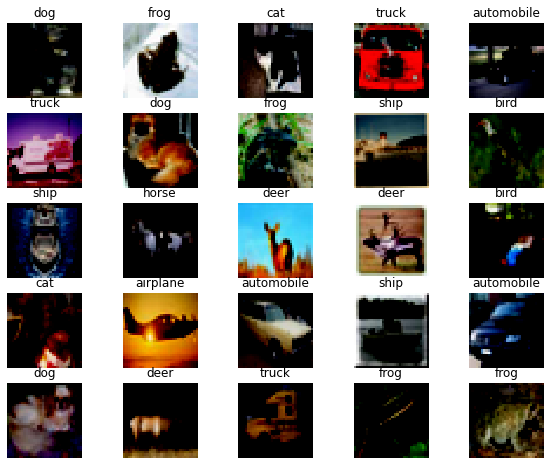

In [18]:
import matplotlib.pyplot as plt
import numpy as np

figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    ax = figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(np.transpose(img, (1, 2, 0)), interpolation='nearest')
    ax.set_title(classes[label])
plt.show()

frog


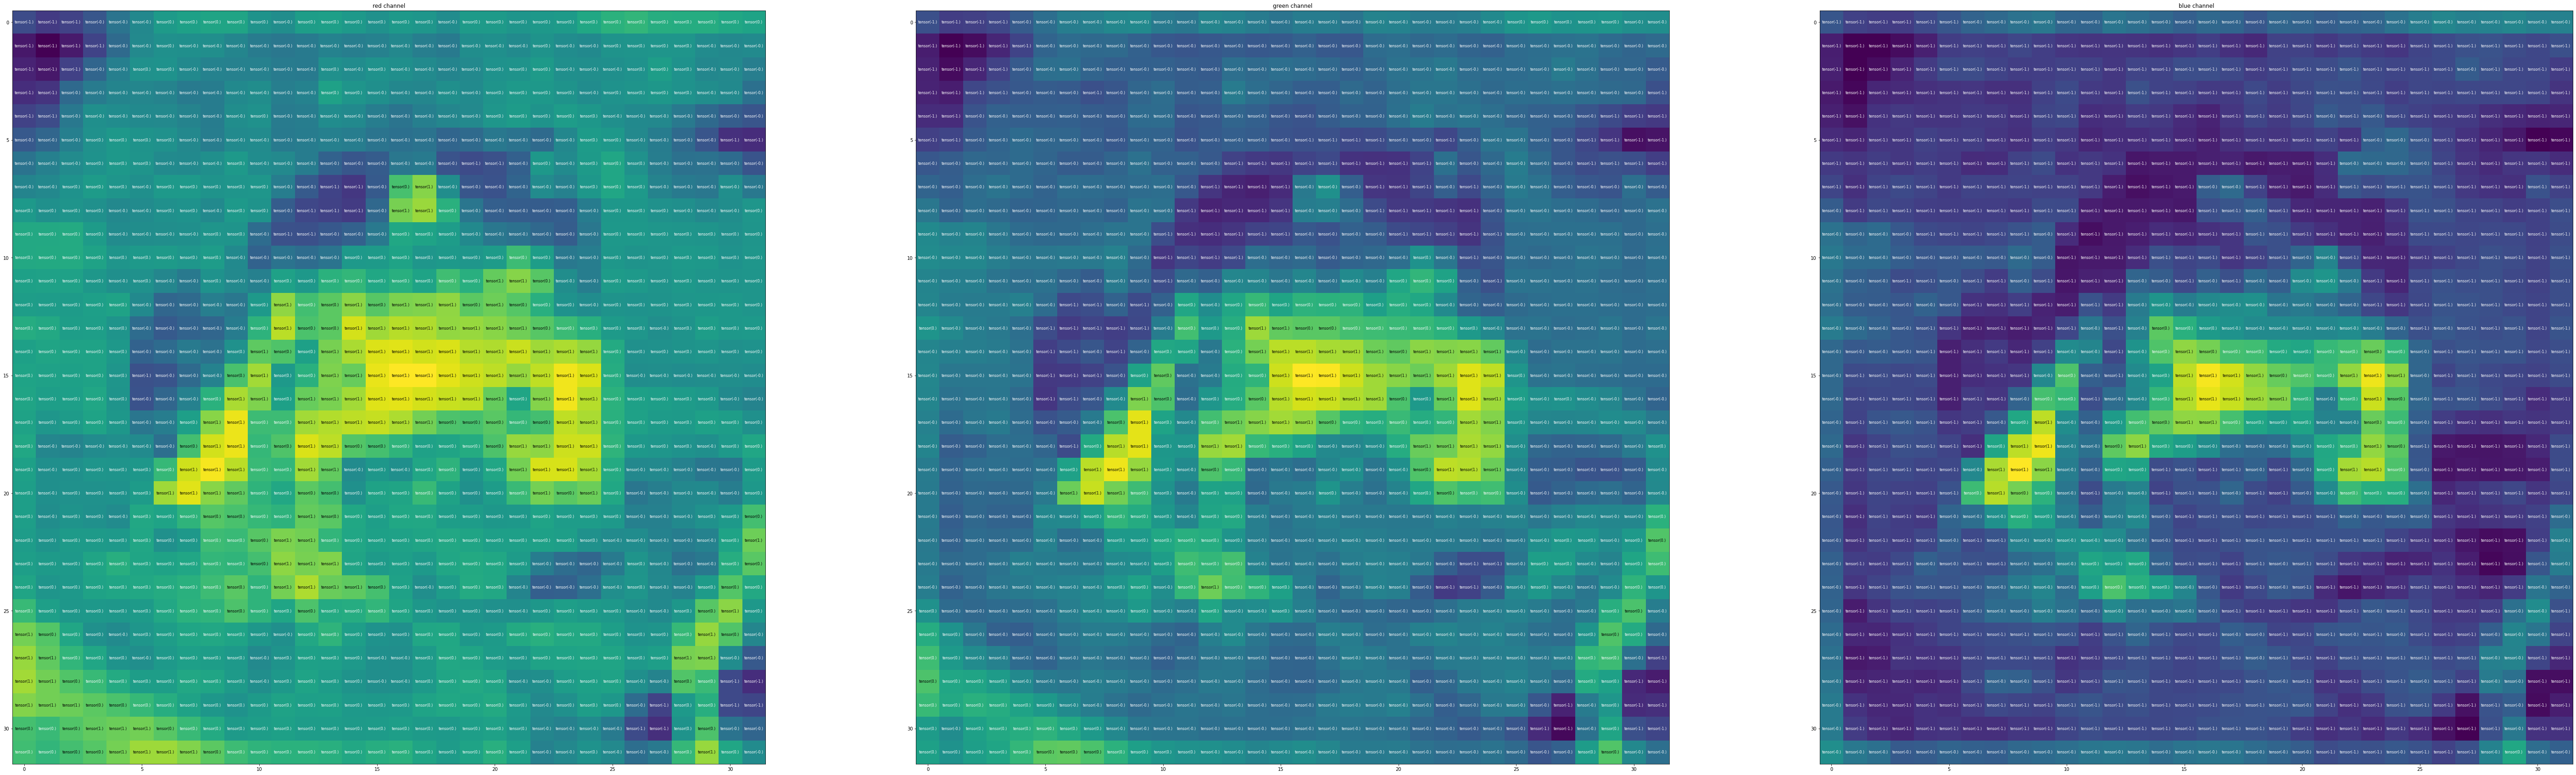

In [15]:
#inspect the image
image, label = train_data[0]
rgb_img = np.squeeze(image)
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize=(100,100))
print(classes[label])
for idx in range(rgb_img.shape[0]):
  ax = fig.add_subplot(1,3,idx+1)
  img = rgb_img[idx]
  ax.imshow(img)
  ax.set_title(channels[idx])
  width, height = img.shape
  threshold = img.max()/2.5
  for x in range(width):
      for y in range(height):
          val = np.round(img[x][y]) if img[x][y] !=0 else 0
          ax.annotate(str(val), xy=(y,x),
                  horizontalalignment='center',
                  verticalalignment='center', size=8,
                  color='white' if img[x][y] < threshold else 'black')

In [30]:
image.shape

torch.Size([3, 32, 32])

### Kernel Size Tuning

In [43]:
import torch.nn as nn
import torch.nn.functional as F
# define the CNN architecture

class CNN(nn.Module):
  def __init__(self, kernel_size):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=kernel_size)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=kernel_size)
    self.fc1 = nn.LazyLinear(out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=84)
    self.fc3 = nn.Linear(in_features=84, out_features=10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [46]:
num_epochs = 30
kernel_sizes = [1,3,5,7,9]
test_acc = []
for kernel_size in kernel_sizes:
  model = CNN(kernel_size)
  cel= nn.CrossEntropyLoss()
  model.cuda()
  opt = optim.Adam(model.parameters(), lr = 0.001)
  train_loss, train_acc, valid_loss, valid_acc = train_with_earlyStoping(model, cel, opt, num_epochs, loaders, islogging=False)
  acc = test(model,loaders)
  test_acc.append(acc)
  print('Kernel size: {}  Test Accuracy of the model on the 10000 test images: {:.4f}'.format(kernel_size, acc))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Kernel size: 1  Test Accuracy of the model on the 10000 test images: 0.5773
Kernel size: 3  Test Accuracy of the model on the 10000 test images: 0.6111
Kernel size: 5  Test Accuracy of the model on the 10000 test images: 0.6170
Kernel size: 7  Test Accuracy of the model on the 10000 test images: 0.5790
Kernel size: 9  Test Accuracy of the model on the 10000 test images: 0.5723


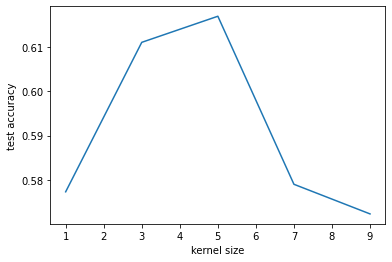

In [47]:
plt.plot(kernel_sizes, test_acc)
plt.xlabel('kernel size')
plt.ylabel('test accuracy')
plt.show()

### Adding More Convolution Layers

In [103]:
import torch.nn as nn
import torch.nn.functional as F
# define the CNN architecture

class CNN1(nn.Module):
  def __init__(self):
    super(CNN1, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
    self.fc1 = nn.LazyLinear(120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [105]:
num_epochs = 30
model1 = CNN1()
cle = nn.CrossEntropyLoss()   
model1.cuda()
adam = optim.Adam(model1.parameters(), lr = 0.001) 
train_loss1, train_acc1, valid_loss1, valid_acc1 = train_with_earlyStoping(model1, cle, adam, num_epochs, loaders, True)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/30], Training Loss: 1.7335, Training Accuracy: 0.3650, Validation Loss: 1.4980, Validation Accuracy: 0.4442
Epoch [2/30], Training Loss: 1.4512, Training Accuracy: 0.4695, Validation Loss: 1.4472, Validation Accuracy: 0.4700
Epoch [3/30], Training Loss: 1.3405, Training Accuracy: 0.5123, Validation Loss: 1.3983, Validation Accuracy: 0.4550
Epoch [4/30], Training Loss: 1.2585, Training Accuracy: 0.5460, Validation Loss: 1.1953, Validation Accuracy: 0.5900
Epoch [5/30], Training Loss: 1.1869, Training Accuracy: 0.5741, Validation Loss: 1.1892, Validation Accuracy: 0.5700
Epoch [6/30], Training Loss: 1.1279, Training Accuracy: 0.5954, Validation Loss: 1.1294, Validation Accuracy: 0.6150
Epoch [7/30], Training Loss: 1.0777, Training Accuracy: 0.6167, Validation Loss: 1.2232, Validation Accuracy: 0.5500
Epoch [8/30], Training Loss: 1.0234, Training Accuracy: 0.6369, Validation Loss: 1.1536, Validation Accuracy: 0.5950
Epoch [9/30], Training Loss: 0.9852, Training Accuracy: 0.6508, 

In [112]:
class CNN2(nn.Module):
  def __init__(self):
      super(CNN2, self).__init__()
      self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
      self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
      self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
      self.pool = nn.MaxPool2d(2, 2)
      self.fc1 = nn.Linear(64 * 4 * 4, 512)
      self.fc2 = nn.Linear(512, 64)
      self.fc3 = nn.Linear(64, 10)

  def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = self.pool(F.relu(self.conv3(x)))
      x = x.view(-1, 64 * 4 * 4)
      x = self.dropout(F.relu(self.fc1(x)))
      x = self.dropout(F.relu(self.fc2(x)))
      x = self.fc3(x)
      return x

In [83]:
num_epochs = 30
model2 = CNN2()
cle= nn.CrossEntropyLoss()  
model2.cuda() 
adam = optim.Adam(model2.parameters(), lr = 0.001) 
train_loss2, train_acc2, valid_loss2, valid_acc2 = train_with_earlyStoping(model2, cle, adam, num_epochs, loaders, True)

Epoch [1/30], Training Loss: 1.7819, Training Accuracy: 0.3355, Validation Loss: 1.4102, Validation Accuracy: 0.5000
Epoch [2/30], Training Loss: 1.4287, Training Accuracy: 0.4821, Validation Loss: 1.3292, Validation Accuracy: 0.5600
Epoch [3/30], Training Loss: 1.2886, Training Accuracy: 0.5439, Validation Loss: 1.2701, Validation Accuracy: 0.5350
Epoch [4/30], Training Loss: 1.1782, Training Accuracy: 0.5851, Validation Loss: 1.1402, Validation Accuracy: 0.5300
Epoch [5/30], Training Loss: 1.0883, Training Accuracy: 0.6206, Validation Loss: 1.0758, Validation Accuracy: 0.6033
Epoch [6/30], Training Loss: 1.0106, Training Accuracy: 0.6494, Validation Loss: 0.8451, Validation Accuracy: 0.6950
Epoch [7/30], Training Loss: 0.9407, Training Accuracy: 0.6764, Validation Loss: 0.8785, Validation Accuracy: 0.7000
Epoch [8/30], Training Loss: 0.8839, Training Accuracy: 0.6976, Validation Loss: 0.8592, Validation Accuracy: 0.6600
Epoch [9/30], Training Loss: 0.8377, Training Accuracy: 0.7159, 

In [109]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x.view(-1, 3*32*32)
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

In [110]:
model3 = CNN3()
num_epochs = 30
cle = nn.CrossEntropyLoss()   
model3.cuda()
adam = optim.Adam(model3.parameters(), lr = 0.001) 
train_loss3, train_acc3, valid_loss3, valid_acc3 = train_with_earlyStoping(model3, cle, adam, num_epochs, loaders, True)

Epoch [1/30], Training Loss: 1.6673, Training Accuracy: 0.3712, Validation Loss: 1.2342, Validation Accuracy: 0.5422
Epoch [2/30], Training Loss: 1.1341, Training Accuracy: 0.5924, Validation Loss: 0.9287, Validation Accuracy: 0.6600
Epoch [3/30], Training Loss: 0.8498, Training Accuracy: 0.6947, Validation Loss: 0.8140, Validation Accuracy: 0.7125
Epoch [4/30], Training Loss: 0.6707, Training Accuracy: 0.7632, Validation Loss: 0.6617, Validation Accuracy: 0.7667
Epoch [5/30], Training Loss: 0.5324, Training Accuracy: 0.8140, Validation Loss: 0.6274, Validation Accuracy: 0.7500
Epoch [6/30], Training Loss: 0.4137, Training Accuracy: 0.8538, Validation Loss: 0.7550, Validation Accuracy: 0.7900
Epoch [7/30], Training Loss: 0.3084, Training Accuracy: 0.8899, Validation Loss: 0.6226, Validation Accuracy: 0.8300
Epoch [8/30], Training Loss: 0.2275, Training Accuracy: 0.9212, Validation Loss: 0.8093, Validation Accuracy: 0.7600
Epoch [9/30], Training Loss: 0.1771, Training Accuracy: 0.9382, 

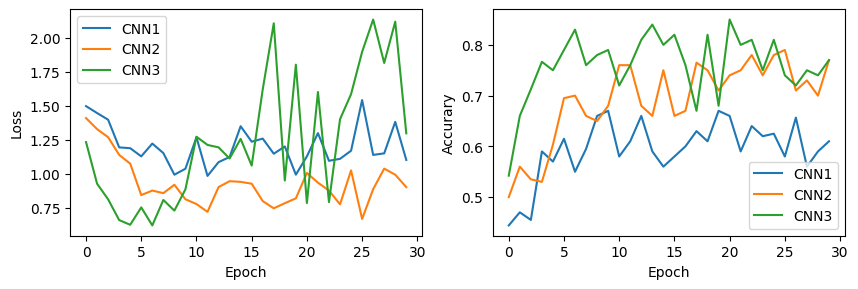

In [111]:
x = [i for i in range(num_epochs)]
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,3), dpi=100)
ax1.plot(x, valid_loss1, label='CNN1')
ax1.plot(x, valid_loss2, label='CNN2')
ax1.plot(x, valid_loss3, label='CNN3')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(x, valid_acc1, label='CNN1')
ax2.plot(x, valid_acc2, label='CNN2')
ax2.plot(x, valid_acc3, label='CNN3')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accurary")
ax2.legend()
plt.show()

In [ ]:
# without batch norm
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [17]:
num_epochs = 30
model = CNN()
cel= nn.CrossEntropyLoss()
model.cuda()
opt = optim.Adam(model.parameters(), lr = 0.001)
train_loss_noBN, train_acc_noBN, valid_loss_noBN, valid_acc_noBN = train_with_earlyStoping(model, cel, opt, num_epochs, loaders)

Epoch [1/30], Training Loss: 1.7839, Training Accuracy: 0.3478, Validation Loss: 1.6181, Validation Accuracy: 0.3956
Epoch [2/30], Training Loss: 1.5014, Training Accuracy: 0.4512, Validation Loss: 1.3889, Validation Accuracy: 0.4950
Epoch [3/30], Training Loss: 1.3732, Training Accuracy: 0.5040, Validation Loss: 1.3853, Validation Accuracy: 0.5100
Epoch [4/30], Training Loss: 1.2889, Training Accuracy: 0.5382, Validation Loss: 1.1847, Validation Accuracy: 0.5400
Epoch [5/30], Training Loss: 1.2207, Training Accuracy: 0.5629, Validation Loss: 1.1615, Validation Accuracy: 0.5750
Epoch [6/30], Training Loss: 1.1583, Training Accuracy: 0.5865, Validation Loss: 1.2255, Validation Accuracy: 0.6100
Epoch [7/30], Training Loss: 1.1083, Training Accuracy: 0.6057, Validation Loss: 1.1424, Validation Accuracy: 0.5700
Epoch [8/30], Training Loss: 1.0617, Training Accuracy: 0.6238, Validation Loss: 1.1989, Validation Accuracy: 0.5500
Epoch [9/30], Training Loss: 1.0239, Training Accuracy: 0.6374, 

In [12]:
class CNN_batchnorm(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.BatchNorm2d(6),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.BatchNorm2d(16),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120),
        nn.Linear(120, 84),
        nn.Linear(84, 10)
    )

  def forward(self, x):
    return self.model(x)

In [13]:
model = CNN_batchnorm()
model

CNN_batchnorm(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=400, out_features=120, bias=True)
    (10): Linear(in_features=120, out_features=84, bias=True)
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [18]:
num_epochs = 30
model = CNN_batchnorm()
cel= nn.CrossEntropyLoss()
model.cuda()
opt = optim.Adam(model.parameters(), lr = 0.001)
train_loss_BN, train_acc_BN, valid_loss_BN, valid_acc_BN = train_with_earlyStoping(model, cel, opt, num_epochs, loaders)

Epoch [1/30], Training Loss: 1.4714, Training Accuracy: 0.4709, Validation Loss: 1.2756, Validation Accuracy: 0.5450
Epoch [2/30], Training Loss: 1.2243, Training Accuracy: 0.5653, Validation Loss: 1.1497, Validation Accuracy: 0.5600
Epoch [3/30], Training Loss: 1.1352, Training Accuracy: 0.5993, Validation Loss: 1.1803, Validation Accuracy: 0.5800
Epoch [4/30], Training Loss: 1.0975, Training Accuracy: 0.6157, Validation Loss: 1.0176, Validation Accuracy: 0.6533
Epoch [5/30], Training Loss: 1.0542, Training Accuracy: 0.6327, Validation Loss: 1.0892, Validation Accuracy: 0.5900
Epoch [6/30], Training Loss: 1.0363, Training Accuracy: 0.6377, Validation Loss: 1.1664, Validation Accuracy: 0.5900
Epoch [7/30], Training Loss: 1.0135, Training Accuracy: 0.6457, Validation Loss: 1.0586, Validation Accuracy: 0.6400
Epoch [8/30], Training Loss: 0.9944, Training Accuracy: 0.6517, Validation Loss: 1.1080, Validation Accuracy: 0.6600
Epoch [9/30], Training Loss: 0.9882, Training Accuracy: 0.6549, 

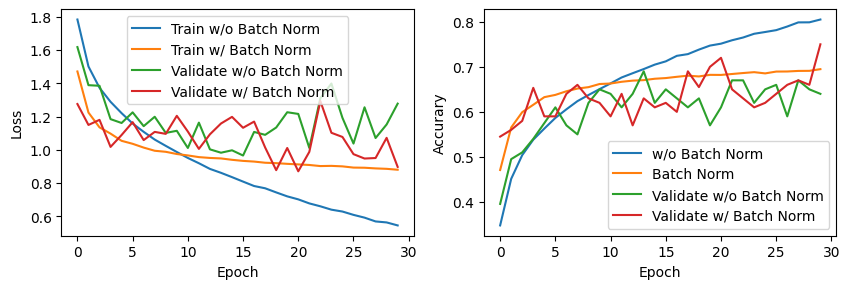

In [19]:
x = [i for i in range(num_epochs)]
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,3), dpi=100)
ax1.plot(x, train_loss_noBN, label='Train w/o Batch Norm')
ax1.plot(x, train_loss_BN, label='Train w/ Batch Norm')
ax1.plot(x, valid_loss_noBN, label='Validate w/o Batch Norm')
ax1.plot(x, valid_loss_BN, label='Validate w/ Batch Norm')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(x, train_acc_noBN, label='w/o Batch Norm')
ax2.plot(x, train_acc_BN, label='Batch Norm')
ax2.plot(x, valid_acc_noBN, label='Validate w/o Batch Norm')
ax2.plot(x, valid_acc_BN, label='Validate w/ Batch Norm')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accurary")
ax2.legend()
plt.show()

In [12]:
model1 = CNN1()
model1

CNN1(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [48]:
num_epochs = 30
model1 = CNN1()
mse= nn.MSELoss()
model1.cuda()
opt = optim.Adam(model1.parameters(), lr = 0.001)
train_loss_mse, train_acc_mse, valid_loss_mse, valid_acc_mse = train_with_earlyStoping(model1, mse, opt, num_epochs, loaders, islogging=True, early_stop=5,one_hot=True)

Epoch [1/30], Training Loss: 0.0764, Training Accuracy: 0.3739, Validation Loss: 0.0677, Validation Accuracy: 0.4909
Epoch [2/30], Training Loss: 0.0654, Training Accuracy: 0.4986, Validation Loss: 0.0638, Validation Accuracy: 0.4950
Epoch [3/30], Training Loss: 0.0602, Training Accuracy: 0.5491, Validation Loss: 0.0661, Validation Accuracy: 0.5000
Epoch [4/30], Training Loss: 0.0567, Training Accuracy: 0.5779, Validation Loss: 0.0563, Validation Accuracy: 0.5900
Epoch [5/30], Training Loss: 0.0542, Training Accuracy: 0.6009, Validation Loss: 0.0567, Validation Accuracy: 0.5900
Epoch [6/30], Training Loss: 0.0521, Training Accuracy: 0.6217, Validation Loss: 0.0508, Validation Accuracy: 0.6100
Epoch [7/30], Training Loss: 0.0503, Training Accuracy: 0.6351, Validation Loss: 0.0566, Validation Accuracy: 0.6000
Epoch [8/30], Training Loss: 0.0490, Training Accuracy: 0.6469, Validation Loss: 0.0530, Validation Accuracy: 0.5900
Epoch [9/30], Training Loss: 0.0471, Training Accuracy: 0.6640, 

In [14]:
num_epochs = 30
model1 = CNN1()
cel= nn.CrossEntropyLoss()
model1.cuda()
opt = optim.Adam(model1.parameters(), lr = 0.001)
train_loss_cel, train_acc_cel, valid_loss_cel, valid_acc_cel = train_with_earlyStoping(model1, cel, opt, num_epochs, loaders)

Epoch [1/30], Training Loss: 1.7148, Training Accuracy: 0.3639, Validation Loss: 1.6036, Validation Accuracy: 0.4256
Epoch [2/30], Training Loss: 1.4438, Training Accuracy: 0.4751, Validation Loss: 1.3660, Validation Accuracy: 0.5033
Epoch [3/30], Training Loss: 1.3282, Training Accuracy: 0.5230, Validation Loss: 1.3325, Validation Accuracy: 0.5000
Epoch [4/30], Training Loss: 1.2393, Training Accuracy: 0.5564, Validation Loss: 1.1936, Validation Accuracy: 0.5750
Epoch [5/30], Training Loss: 1.1687, Training Accuracy: 0.5851, Validation Loss: 1.2256, Validation Accuracy: 0.5700
Epoch [6/30], Training Loss: 1.1181, Training Accuracy: 0.6040, Validation Loss: 1.1086, Validation Accuracy: 0.6150
Epoch [7/30], Training Loss: 1.0677, Training Accuracy: 0.6207, Validation Loss: 1.3498, Validation Accuracy: 0.5200
Epoch [8/30], Training Loss: 1.0284, Training Accuracy: 0.6359, Validation Loss: 1.2434, Validation Accuracy: 0.6000
Epoch [9/30], Training Loss: 0.9911, Training Accuracy: 0.6490, 

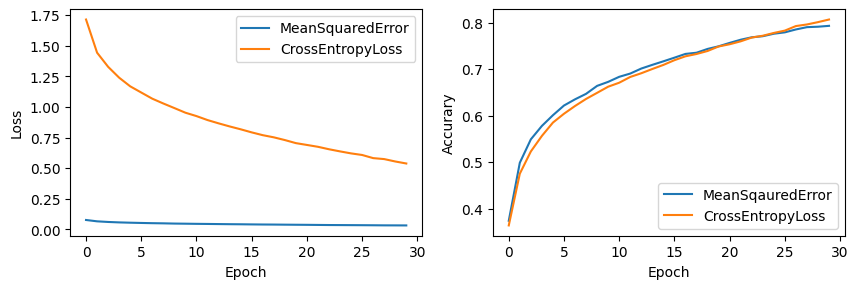

In [50]:
x = [i for i in range(num_epochs)]
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,3), dpi=100)
ax1.plot(x, train_loss_mse, label='MeanSquaredError')
ax1.plot(x, train_loss_cel, label='CrossEntropyLoss')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(x, train_acc_mse, label='MeanSqauredError')
ax2.plot(x, train_acc_cel, label='CrossEntropyLoss')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accurary")
ax2.legend()
plt.show()

In [22]:
num_epochs = 30
model1 = CNN1()
cel= nn.CrossEntropyLoss()
model1.cuda()
sgd = optim.SGD(model1.parameters(), lr = 0.001)
train_loss_sgd, train_acc_sgd, valid_loss_sgd, valid_acc_sgd = train_with_earlyStoping(model1, cel, sgd, num_epochs, loaders, True)

Epoch [1/30], Training Loss: 2.3054, Training Accuracy: 0.1052, Validation Loss: 2.3079, Validation Accuracy: 0.1055
Epoch [2/30], Training Loss: 2.3054, Training Accuracy: 0.1052, Validation Loss: 2.2999, Validation Accuracy: 0.0900
Epoch [3/30], Training Loss: 2.3054, Training Accuracy: 0.1052, Validation Loss: 2.3160, Validation Accuracy: 0.0700
Epoch [4/30], Training Loss: 2.3054, Training Accuracy: 0.1052, Validation Loss: 2.2959, Validation Accuracy: 0.1500
Epoch [5/30], Training Loss: 2.3054, Training Accuracy: 0.1052, Validation Loss: 2.2969, Validation Accuracy: 0.1100
Epoch [6/30], Training Loss: 2.3054, Training Accuracy: 0.1052, Validation Loss: 2.3142, Validation Accuracy: 0.1000
Epoch [7/30], Training Loss: 2.3054, Training Accuracy: 0.1052, Validation Loss: 2.3199, Validation Accuracy: 0.0800
Epoch [8/30], Training Loss: 2.3054, Training Accuracy: 0.1052, Validation Loss: 2.2988, Validation Accuracy: 0.1100
Epoch [9/30], Training Loss: 2.3054, Training Accuracy: 0.1052, 

In [20]:
num_epochs = 30
model1 = CNN1()
cel= nn.CrossEntropyLoss()
model1.cuda()
adagrad = optim.Adagrad(model1.parameters(), lr = 0.001)
train_loss_adagrad, train_acc_adagrad, valid_loss_adagrad, valid_acc_adagrad = train_with_earlyStoping(model1, cel, adagrad, num_epochs, loaders, True)

Epoch [1/30], Training Loss: 1.9701, Training Accuracy: 0.2824, Validation Loss: 1.8456, Validation Accuracy: 0.3122
Epoch [2/30], Training Loss: 1.8137, Training Accuracy: 0.3386, Validation Loss: 1.7548, Validation Accuracy: 0.3400
Epoch [3/30], Training Loss: 1.7640, Training Accuracy: 0.3588, Validation Loss: 1.7462, Validation Accuracy: 0.3400
Epoch [4/30], Training Loss: 1.7331, Training Accuracy: 0.3698, Validation Loss: 1.7203, Validation Accuracy: 0.3900
Epoch [5/30], Training Loss: 1.7104, Training Accuracy: 0.3781, Validation Loss: 1.6841, Validation Accuracy: 0.4000
Epoch [6/30], Training Loss: 1.6923, Training Accuracy: 0.3858, Validation Loss: 1.7459, Validation Accuracy: 0.3800
Epoch [7/30], Training Loss: 1.6776, Training Accuracy: 0.3895, Validation Loss: 1.6504, Validation Accuracy: 0.4000
Epoch [8/30], Training Loss: 1.6652, Training Accuracy: 0.3964, Validation Loss: 1.6943, Validation Accuracy: 0.4400
Epoch [9/30], Training Loss: 1.6545, Training Accuracy: 0.3986, 

In [23]:
num_epochs = 30
model1 = CNN1()
cel = nn.CrossEntropyLoss()   
model1.cuda()
rmsprop = optim.RMSprop(model1.parameters(), lr = 0.001)
train_loss_rmsprop, train_acc_rmsprop, valid_loss_rmsprop, valid_acc_rmsprop = train_with_earlyStoping(model1, cel, rmsprop, num_epochs, loaders, True)

Epoch [1/30], Training Loss: 1.7032, Training Accuracy: 0.3746, Validation Loss: 1.4952, Validation Accuracy: 0.4500
Epoch [2/30], Training Loss: 1.4333, Training Accuracy: 0.4802, Validation Loss: 1.3570, Validation Accuracy: 0.4967
Epoch [3/30], Training Loss: 1.3309, Training Accuracy: 0.5178, Validation Loss: 1.3206, Validation Accuracy: 0.5050
Epoch [4/30], Training Loss: 1.2681, Training Accuracy: 0.5430, Validation Loss: 1.2826, Validation Accuracy: 0.5150
Epoch [5/30], Training Loss: 1.2137, Training Accuracy: 0.5630, Validation Loss: 1.2810, Validation Accuracy: 0.5200
Epoch [6/30], Training Loss: 1.1632, Training Accuracy: 0.5811, Validation Loss: 1.2179, Validation Accuracy: 0.5850
Epoch [7/30], Training Loss: 1.1269, Training Accuracy: 0.6007, Validation Loss: 1.1592, Validation Accuracy: 0.6200
Epoch [8/30], Training Loss: 1.0863, Training Accuracy: 0.6106, Validation Loss: 1.0998, Validation Accuracy: 0.6050
Epoch [9/30], Training Loss: 1.0510, Training Accuracy: 0.6254, 

In [71]:
num_epochs = 30
model1 = CNN1()
cel = nn.CrossEntropyLoss()  
model1.cuda() 
adam = optim.Adam(model1.parameters(), lr = 0.001) 
train_loss_adam, train_acc_adam, valid_loss_adam, valid_acc_adam = train_with_earlyStoping(model1, cel, adam, num_epochs, loaders, True)

Epoch [1/30], Training Loss: 1.7817, Training Accuracy: 0.3448, Validation Loss: 1.5636, Validation Accuracy: 0.4240
Epoch [2/30], Training Loss: 1.4659, Training Accuracy: 0.4674, Validation Loss: 1.5945, Validation Accuracy: 0.4200
Epoch [3/30], Training Loss: 1.3557, Training Accuracy: 0.5118, Validation Loss: 1.4268, Validation Accuracy: 0.5000
Epoch [4/30], Training Loss: 1.2661, Training Accuracy: 0.5468, Validation Loss: 1.1651, Validation Accuracy: 0.6150
Epoch [5/30], Training Loss: 1.1995, Training Accuracy: 0.5709, Validation Loss: 1.3783, Validation Accuracy: 0.4800
Epoch [6/30], Training Loss: 1.1402, Training Accuracy: 0.5948, Validation Loss: 1.1269, Validation Accuracy: 0.5900
Epoch [7/30], Training Loss: 1.0954, Training Accuracy: 0.6114, Validation Loss: 1.2670, Validation Accuracy: 0.5500
Epoch [8/30], Training Loss: 1.0529, Training Accuracy: 0.6273, Validation Loss: 1.1375, Validation Accuracy: 0.5800
Epoch [9/30], Training Loss: 1.0135, Training Accuracy: 0.6427, 

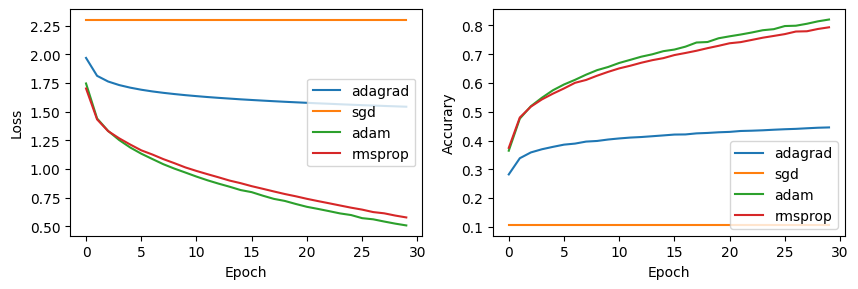

In [37]:
x = [i for i in range(num_epochs)]
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,3), dpi=100)
ax1.plot(x, train_loss_adagrad, label='adagrad')
ax1.plot(x, train_loss_sgd, label='sgd')
ax1.plot(x, train_loss_adam, label='adam')
ax1.plot(x, train_loss_rmsprop, label='rmsprop')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(x, train_acc_adagrad, label='adagrad')
ax2.plot(x, train_acc_sgd, label='sgd')
ax2.plot(x, train_acc_adam, label='adam')
ax2.plot(x, train_acc_rmsprop, label='rmsprop')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accurary")
ax2.legend()
plt.show()

### MLP vs. ConvNet

In [54]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(3*32*32, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def forward(self, x):
    # print(x.size())
    x = x.view(-1, 3*32*32)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    return x

In [67]:
mlp = MLP()
mlp

MLP(
  (fc1): Linear(in_features=3072, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [68]:
num_epochs = 30

cel = nn.CrossEntropyLoss()  
mlp.cuda() 
adam = optim.Adam(mlp.parameters(), lr = 0.001) 
train_loss_mlp, train_acc_mlp, valid_loss_mlp, valid_acc_mlp = train_with_earlyStoping(mlp, cel, adam, num_epochs, loaders, True, early_stop=3)

Epoch [1/30], Training Loss: 1.7164, Training Accuracy: 0.3964, Validation Loss: 1.5565, Validation Accuracy: 0.4586
Epoch [2/30], Training Loss: 1.4868, Training Accuracy: 0.4760, Validation Loss: 1.4662, Validation Accuracy: 0.5700
Epoch [3/30], Training Loss: 1.3861, Training Accuracy: 0.5132, Validation Loss: 1.4894, Validation Accuracy: 0.4950
Epoch [4/30], Training Loss: 1.3116, Training Accuracy: 0.5417, Validation Loss: 1.7147, Validation Accuracy: 0.4100
Epoch [5/30], Training Loss: 1.2504, Training Accuracy: 0.5602, Validation Loss: 1.5554, Validation Accuracy: 0.5500
Epoch [6/30], Training Loss: 1.1929, Training Accuracy: 0.5814, Validation Loss: 1.5056, Validation Accuracy: 0.4500
Epoch [7/30], Training Loss: 1.1388, Training Accuracy: 0.6013, Validation Loss: 1.3301, Validation Accuracy: 0.5300
Epoch [8/30], Training Loss: 1.0942, Training Accuracy: 0.6150, Validation Loss: 1.5536, Validation Accuracy: 0.4500
Epoch [9/30], Training Loss: 1.0487, Training Accuracy: 0.6350, 

In [58]:
acc = test(mlp, loaders)
print('MLP, Test Accuracy of the model on the 10000 test images: {:.4f}'.format(acc))

MLP, Test Accuracy of the model on the 10000 test images: 0.4937


In [73]:
num_epochs = 30
cnn = CNN1()
cel = nn.CrossEntropyLoss()  
cnn.cuda() 
adam = optim.Adam(cnn.parameters(), lr = 0.001) 
train_loss_cnn, train_acc_cnn, valid_loss_cnn, valid_acc_cnn = train_with_earlyStoping(cnn, cel, adam, num_epochs, loaders, True)

Epoch [1/30], Training Loss: 1.7479, Training Accuracy: 0.3580, Validation Loss: 1.5553, Validation Accuracy: 0.4230
Epoch [2/30], Training Loss: 1.4502, Training Accuracy: 0.4723, Validation Loss: 1.3894, Validation Accuracy: 0.5000
Epoch [3/30], Training Loss: 1.3298, Training Accuracy: 0.5203, Validation Loss: 1.4624, Validation Accuracy: 0.5500
Epoch [4/30], Training Loss: 1.2512, Training Accuracy: 0.5544, Validation Loss: 1.2474, Validation Accuracy: 0.5700
Epoch [5/30], Training Loss: 1.1913, Training Accuracy: 0.5747, Validation Loss: 1.3269, Validation Accuracy: 0.5300
Epoch [6/30], Training Loss: 1.1322, Training Accuracy: 0.5970, Validation Loss: 1.1956, Validation Accuracy: 0.5800
Epoch [7/30], Training Loss: 1.0910, Training Accuracy: 0.6121, Validation Loss: 1.2127, Validation Accuracy: 0.5950
Epoch [8/30], Training Loss: 1.0522, Training Accuracy: 0.6267, Validation Loss: 1.1144, Validation Accuracy: 0.6600
Epoch [9/30], Training Loss: 1.0164, Training Accuracy: 0.6407, 

In [75]:
acc = test(cnn, loaders)
print('CNN, Test Accuracy of the model on the 10000 test images: {:.4f}'.format(acc))

CNN, Test Accuracy of the model on the 10000 test images: 0.6294


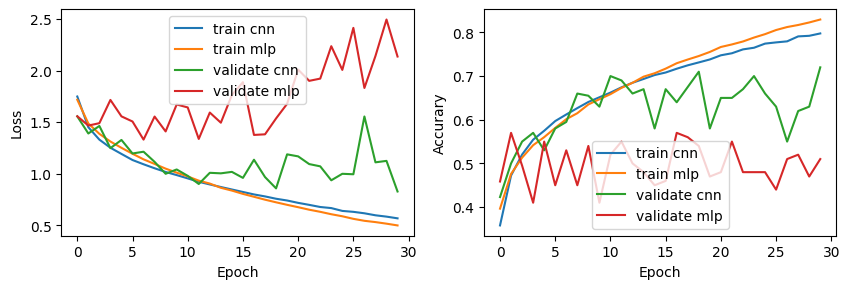

In [76]:
x = [i for i in range(num_epochs)]
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,3), dpi=100)
ax1.plot(x, train_loss_cnn, label='train cnn')
ax1.plot(x, train_loss_mlp, label='train mlp')
ax1.plot(x, valid_loss_cnn, label='validate cnn')
ax1.plot(x, valid_loss_mlp, label='validate mlp')
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax2.plot(x, train_acc_cnn, label='train cnn')
ax2.plot(x, train_acc_mlp, label='train mlp')
ax2.plot(x, valid_acc_cnn, label='validate cnn')
ax2.plot(x, valid_acc_mlp, label='validate mlp')
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accurary")
ax2.legend()
plt.show()

### Final Model

In [125]:
class CNN_final(nn.Module):
    def __init__(self):
        super(CNN_final, self).__init__()
        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x.view(-1, 3*32*32)
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x

In [126]:
num_epochs = 30
cnn = CNN_final()
cel = nn.CrossEntropyLoss()  
cnn.cuda() 
adam = optim.Adam(cnn.parameters(), lr = 0.001) 
train_loss_cnn, train_acc_cnn, valid_loss_cnn, valid_acc_cnn = train_with_earlyStoping(cnn, cel, adam, num_epochs, loaders, islogging=False)

In [127]:
acc = test(cnn,loaders)
print('Test Accuracy of the model on the 10000 test images: {:.4f}'.format(acc))

Test Accuracy of the model on the 10000 test images: 0.8244
